# Margay Model

<img src="https://conservationcubclub.com/wp-content/uploads/2023/11/Margay.-AI.jpeg" width="300"/>

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
# from torch.cuda.amp import autocast
from matplotlib import pyplot as plt
import time
import numpy as np
import pandas as pd
from collections import OrderedDict

# Check if GPU is available
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('Default GPU Device: {}'.format(torch.cuda.get_device_name(0)))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

MASTER_CONFIG = {
    'n_layers': 4,
    'n_heads': 8,
    'd_model': 11,
    'context_window': 60,
    
    'epochs': 1000,
    'batch_size': 6400,
    'print_logs': True,
    'log_interval': 100,
}

Default GPU Device: NVIDIA L4


tensor device: cuda:0
first 2 rows: tensor([[-2.8836, -2.8954, -1.8443, -2.9108, -0.5372, -1.2822, -3.6037, -2.6096,
         -2.8284, -1.3288,  0.0314],
        [-2.3146, -2.3433,  0.1063, -2.5521, -1.5556, -1.1687, -2.3212, -1.6106,
         -2.3902, -0.2568,  0.0105]], device='cuda:0')
shape of dataset: torch.Size([255449, 11])
standard deviation: 1.031144
mean: 0.004247


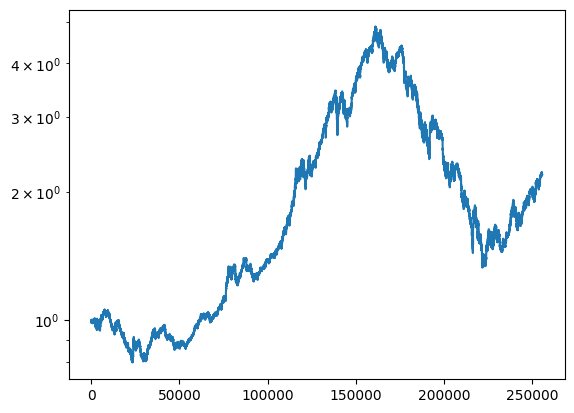

In [2]:
# load index_pc_hist.pkl into a dataframe
df = pd.read_pickle('../data/index_pct_hist.pkl')

# drop rows that contains NaN
# pre-rescaling
# std = 0.001031, mean = 0.000004
# post-rescaling
# std = 1.031144, mean = 0.004247
index_scale_factor = 1000
df = df.dropna() * index_scale_factor

# convert the dataframe to a tensor
dataset = torch.from_numpy(df.values).to(device)

print(f'tensor device: {dataset.device}')
print(f'first 2 rows: {dataset[:2,: ]}')
print(f'shape of dataset: {dataset.shape}')
print(f'standard deviation: {dataset.std():.6f}')
print(f'mean: {dataset.mean():.6f}')

# iterate through dataset
sh1a0001 = [1]
for i in range(len(dataset)):
    sh1a0001.append(sh1a0001[-1] * (1 + dataset[i, 0] / index_scale_factor).to('cpu'))
# plot sh1a0001 # linear chart
plt.semilogy(sh1a0001) # log chart

In [3]:
def get_batches(data, split, config=MASTER_CONFIG, extraY=0):
    train = data[:int(.8 * len(data))]
    valid = data[int(.8 * len(data)): int(.9 * len(data))]
    test  = data[int(.9 * len(data)):]

    batch_data = train
    if split in ['valid', 'val', 'validation']:
        batch_data = valid
    elif split in ['test', 'testing']:
        batch_data = test
    
    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - config['context_window']-extraY, (config['batch_size'],))
    x = torch.stack([batch_data[i:i+config['context_window']] for i in ix])
    y = torch.stack([batch_data[i+1:i+config['context_window']+1+extraY] for i in ix])
    return x, y

# 1. n-gram model
Linear → ReLU → Linear

In [4]:
@torch.inference_mode()
def evaluate_loss(model, config=MASTER_CONFIG, size=10, include_test=False):
    out = {}
    model.eval()
    for split in ["train", "val"] + (["test"] if include_test else []):
        losses = []
        for _ in range(size):
            xb, yb = get_batches(dataset, split, config)
            _, loss = model(xb, yb[:,-1,:])
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

## 1.2 Simple MLP

In [ ]:
# n-gram model, predict the next value based on the current value
class NGramModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'] * config['context_window'], config['d_model'] * config['context_window']),
            nn.ReLU(),
            nn.Linear(config['d_model'] * config['context_window'], config['d_model']),
        )

        print(f"model params: {sum([m.numel() for m in self.parameters()]):,}")

    def forward(self, idx, target=None):
        logits = self.linear(idx.view(idx.size(0), -1))

        assert logits.shape == target.shape, f'target shape {target.shape} does not match logits shape {logits.shape}'
        
        if target is not None:
            loss = F.mse_loss(logits, target)
            return logits, loss

        else:
            return logits
        
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG):
    losses = []
    start_time = time.time()
    tmp = evaluate_loss(model)
    print(f"[before training]\ntrain loss: {tmp['train']:.3f}\nvalid loss: {tmp['val']:.3f}\n")
    
    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        
        xs, ys = get_batches(dataset, 'train', MASTER_CONFIG)
        y = ys[:,-1,:] # for n-gram model only
        logits, loss = model(xs, target=y)

        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if config['print_logs']:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    return pd.DataFrame(losses).plot()

In [ ]:
MASTER_CONFIG.update({
    'batch_size': 6400,
    'context_window': 30,
})

model = NGramModel(MASTER_CONFIG).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), 
)

train(model, optimizer)
tmp_loss = evaluate_loss(model, size=100, include_test=True)
print(f"[AFTER training]\ntrain loss: {tmp_loss['train']:.3f}\nvalid loss: {tmp_loss['val']:.3f}\ntest  loss: {tmp_loss['test']:.3f}\n")

|  | bactch_size | context_win | train loss | valid loss | test loss | train time |
|---|---|---|---|---|---|---|
| NGramModel | 6400 | 1 | 0.744 | 1.911 | | 4m 12s |
| NGramModel | 6400 | 30 | 0.647 | 2.512 | 0.756 | 4m 17s |

## 1.1 n-gram model + RMSNorm

In [4]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [ ]:
# n-gram model, with RMSNorm added
class NGramModel_RMS(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'] * config['context_window'], config['d_model'] * config['context_window']),
            nn.ReLU(),
            nn.Linear(config['d_model'] * config['context_window'], config['d_model']),
        )

        print(f"model params: {sum([m.numel() for m in self.parameters()]):,}")

    # @autocast()
    def forward(self, xs, target=None):
        xs = self.rms(xs)                              # (batch, seq_len, d_model)
        logits = self.linear(xs.view(xs.size(0), -1))  # (batch, d_model)

        assert logits.shape == target.shape, f'target shape {target.shape} does not match logits shape {logits.shape}'
        
        if target is not None:
            loss = F.mse_loss(logits, target)
            return logits, loss

        else:
            return logits
        
#############################################

MASTER_CONFIG.update({
    'batch_size': 6400,
    'context_window': 30,
})

model = NGramModel_RMS(MASTER_CONFIG).to(device)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer)
tmp_loss = evaluate_loss(model, size=100, include_test=True)
print(f"[AFTER training]\ntrain loss: {tmp_loss['train']:.3f}\nvalid loss: {tmp_loss['val']:.3f}\ntest  loss: {tmp_loss['test']:.3f}\n")


|  | bactch_size | context_win | train loss | valid loss | test loss | train time |
|---|---|---|---|---|---|---|
| NGramModel | 6400 | 30 | 0.647 | 2.512 | 0.756 | 4m 17s |
| NGramModel + RMSNorm | 6400 | 30 | 0.601 | 2.452 | 0.818 | 4m 23s |
| NGramModel + RMSNorm w/ autocast | 6400 | 30 | 0.616 | 2.631 | | 4m 36s |

## 1.2 n-gram + RMSNorm + Rotary Embeddings

In [5]:
class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = self.get_rotary_matrix(config['context_window'], config['d_model']).to(device)

    def get_rotary_matrix(self, context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations
    
# definitely there's an optimization we could make where we cache the rotation matrices, but skip.
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


In [ ]:
layer = RoPEMaskedAttentionHead(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()

In [ ]:
# n-gram model, with RMSNorm + RoPE
class NGramModel_RMS_RoPE(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'] * config['context_window'], config['d_model'] * config['context_window']),
            nn.ReLU(),
            nn.Linear(config['d_model'] * config['context_window'], config['d_model']),
        )

        print(f"model params: {sum([m.numel() for m in self.parameters()]):,}")

    # @autocast()
    def forward(self, xs, target=None):
        xs = self.rms(xs)                              # (batch, seq_len, d_model)
        xs = xs + self.rope_attention(xs)              # (batch, seq_len, d_model)

        xs = self.rms(xs)                              # (batch, seq_len, d_model)
        logits = self.linear(xs.view(xs.size(0), -1))  # (batch, d_model)

        assert logits.shape == target.shape, f'target shape {target.shape} does not match logits shape {logits.shape}'
        
        if target is not None:
            loss = F.mse_loss(logits, target)
            return logits, loss

        else:
            return logits
        
#############################################
        
MASTER_CONFIG.update({
    'batch_size': 6400,
    'context_window': 30,
})

model = NGramModel_RMS_RoPE(MASTER_CONFIG).to(device)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer)
tmp_loss = evaluate_loss(model, size=100, include_test=True)
print(f"[AFTER training]\ntrain loss: {tmp_loss['train']:.3f}\nval loss: {tmp_loss['val']:.3f}\ntest loss: {tmp_loss['test']:.3f}")

|  | bactch_size | context_win | train loss | valid loss | test loss | train time |
|---|---|---|---|---|---|---|
| NGramModel | 6400 | 30 | 0.647 | 2.512 | 0.756 | 4m 17s |
| NGramModel + RMSNorm | 6400 | 30 | 0.601 | 2.452 | 0.818 | 4m 23s |
| NGramModel + RMSNorm + RoPE | 6400 | 30 | 0.557 | 2.348 | 0.827 | 5m 17s |

## 1.3 SwiGLU

In [6]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        #self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

In [ ]:
# n-gram model, with RMSNorm + RoPE + SwiGLU
class NGramModel_RMS_RoPE_SwiGLU(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'] * config['context_window'], config['d_model'] * config['context_window']),
            SwiGLU(config['d_model'] * config['context_window']),
            nn.Linear(config['d_model'] * config['context_window'], config['d_model']),
        )

        print(f"model params: {sum([m.numel() for m in self.parameters()]):,}")

    # @autocast()
    def forward(self, xs, target=None):
        xs = self.rms(xs)                              # (batch, seq_len, d_model)
        xs = xs + self.rope_attention(xs)              # (batch, seq_len, d_model)

        xs = self.rms(xs)                              # (batch, seq_len, d_model)
        logits = self.linear(xs.view(xs.size(0), -1))  # (batch, d_model)

        assert logits.shape == target.shape, f'target shape {target.shape} does not match logits shape {logits.shape}'
        
        if target is not None:
            loss = F.mse_loss(logits, target)
            return logits, loss

        else:
            return logits
        
#############################################
        
MASTER_CONFIG.update({
    'batch_size': 6400,
    'context_window': 30,
})

model = NGramModel_RMS_RoPE(MASTER_CONFIG).to(device)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer)
tmp_loss = evaluate_loss(model, size=100, include_test=True)
print(f"[AFTER training]\ntrain loss: {tmp_loss['train']:.3f}\nval loss: {tmp_loss['val']:.3f}\ntest loss: {tmp_loss['test']:.3f}")

|  | bactch_size | context_win | train loss | valid loss | test loss | train time |
|---|---|---|---|---|---|---|
| NGramModel | 6400 | 30 | 0.647 | 2.512 | 0.756 | 4m 17s |
| NGramModel + RMSNorm | 6400 | 30 | 0.601 | 2.452 | 0.818 | 4m 23s |
| NGramModel + RMSNorm + RoPE | 6400 | 30 | 0.557 | 2.348 | 0.827 | 5m 17s |
| NGramModel + RMSNorm + RoPE + SwiGLU | 6400 | 30 | 0.551 | 2.436 | 0.850 | 5m 20s |

# 2. Margay Model (Transformers)

In [7]:
# add RMSNorm and residual conncection
class MargayBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))
        
        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

class Margay(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.margay_blocks = nn.Sequential(
            OrderedDict([(f"margay_{i}", MargayBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['d_model']),
        )

        print(f"model params: {sum([m.numel() for m in self.parameters()]):,}")

    def forward(self, xs, targets=None):
        xs = self.margay_blocks(xs)
        logits = self.ffn(xs)

        if targets is None:
            return logits
        
        else:
            loss = F.mse_loss(logits, targets)
            return logits, loss

@torch.inference_mode()
def evaluate_loss(model, config=MASTER_CONFIG, size=10, include_test=False):
    out = {}
    model.eval()
    for split in ["train", "val"] + (["test"] if include_test else []):
        losses = []
        for _ in range(size):
            xb, yb = get_batches(dataset, split, config)
            _, loss = model(xb, yb)
            
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG):
    losses = []

    tmp_loss = evaluate_loss(model)
    print(f"[BEFORE training]\ntrain loss: {tmp_loss['train']:.3f}\nvalid loss: {tmp_loss['val']:.3f}\n")

    log_start_time = train_start_time = time.time()
    print(f"pre-training started at {time.ctime()}\n")

    total_steps = config['epochs'] * dataset.size(0) // config['batch_size']

    for step in range(total_steps):
        optimizer.zero_grad()
        
        xs, ys = get_batches(dataset, 'train', MASTER_CONFIG)
        logits, loss = model(xs, targets=ys)

        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        if step % config['log_interval'] == 0:
            log_time = time.time() - log_start_time
            x = evaluate_loss(model)
            losses += [x]
            if config['print_logs']:
                print(f"Step {step} | val loss {x['val']:.3f} | Time {log_time:.3f} | ETA in {time.strftime('%H:%M:%S', time.gmtime(log_time * (total_steps - step)/config['log_interval']))}")
            log_start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())
    
    print(f"\ntraining finished in {time.strftime('%H:%M:%S', time.gmtime(time.time() - train_start_time))} at {time.ctime()}\n")

    tmp_loss = evaluate_loss(model, size=100, include_test=True)
    print(f"[AFTER training]\ntrain loss: {tmp_loss['train']:.3f}\nval loss: {tmp_loss['val']:.3f}\ntest loss: {tmp_loss['test']:.3f}")

    return pd.DataFrame(losses).plot()


model params: 20,465
[BEFORE training]
train loss: 0.900
valid loss: 2.878

pre-training started at Wed Jan 17 07:35:40 2024

Step 0 | val loss 2.861 | Time 0.332 | ETA in 00:00:02
Step 100 | val loss 2.800 | Time 12.784 | ETA in 00:01:29
Step 200 | val loss 2.779 | Time 12.828 | ETA in 00:01:16
Step 300 | val loss 2.572 | Time 12.880 | ETA in 00:01:04
Step 400 | val loss 2.491 | Time 12.918 | ETA in 00:00:51
Step 500 | val loss 2.497 | Time 12.965 | ETA in 00:00:38
Step 600 | val loss 2.451 | Time 12.948 | ETA in 00:00:25
Step 700 | val loss 2.461 | Time 12.916 | ETA in 00:00:12

training finished in 00:02:34 at Wed Jan 17 07:38:15 2024

[AFTER training]
train loss: 0.698
val loss: 2.438
test loss: 0.760


<Axes: >

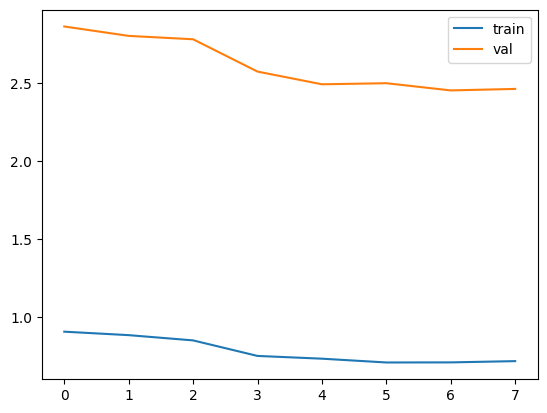

In [8]:
MASTER_CONFIG = {
    'batch_size': 320,
    'd_model': 11,
    'n_heads': 4,
    'context_window': 240,
    'n_layers': 4,
    
    'epochs': 1,
    'log_interval': 100,
    'print_logs': True,
}

margay = Margay(MASTER_CONFIG).to(device)
optimizer = torch.optim.Adam(margay.parameters())
train(margay, optimizer, config=MASTER_CONFIG)

|  | n_params | n_heads | n_layers | bactch size | context win | train loss | valid loss | test loss | train time |
|---|---|---|---|---|---|---|---|---|---|
| NGramModel |  |  |  | 6400 | 30 | 0.647 | 2.512 | 0.756 | 4m 17s |
| NGramModel + RMSNorm |  |  |  | 6400 | 30 | 0.601 | 2.452 | 0.818 | 4m 23s |
| NGramModel + RMSNorm + RoPE |  | 8 |  | 6400 | 30 | 0.557 | 2.348 | 0.827 | 5m 17s |
| NGramModel + RMSNorm + RoPE + SwiGLU |  | 8 |  | 6400 | 30 | 0.551 | 2.436 | 0.850 | 5m 20s |
| MargayModel | 18,969 | 8 | 4 | 6400 | 30 | 0.423 | 1.115 | 0.561 | 8m 39s |

model params: 18,969
[BEFORE training]
train loss: 0.894
valid loss: 2.830

[AFTER training]
train loss: 0.318
val loss: 0.817
test loss: 0.456


<Axes: >

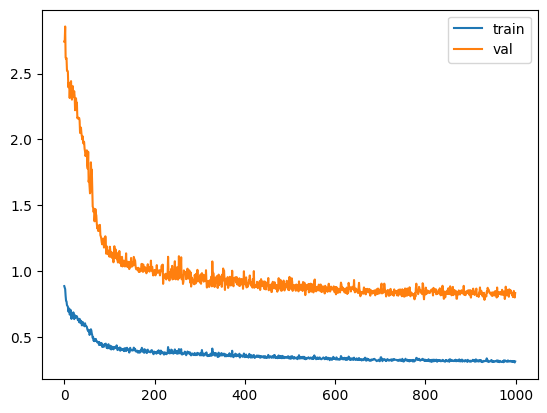

In [ ]:
MASTER_CONFIG = {
    'batch_size': 6400,
    'd_model': 11,
    'n_heads': 8,
    'context_window': 30,
    'n_layers': 4,
    
    'epochs': 10000,
    'log_interval': 500,
    'print_logs': True,
}

margay = Margay(MASTER_CONFIG).to(device)
optimizer = torch.optim.Adam(margay.parameters())
train(margay, optimizer, config=MASTER_CONFIG)

| n_params | n_layers | n_heads | context win | bactch size | epocks | train loss | valid loss | test loss | GPU | train time |
|---|---|---|---|---|---|---|---|---|---|---|
| 18,969 | 4 | 8 | 30 | 6400 | 1k | 0.423 | 1.115 | 0.561 | 2070 | 8m 39s |
| 28,209 | 4 | 8 | 240 | 64 | 1k | 0.718 | 2.447 | 0.792 | 2070 | 5m 47s |
| 18,969 | 4 | 8 | 30 | 6400 | 10k | 0.318 | 0.817 | 0.456 | 2070 | 85m 40s |
| 18,969 | 4 | 8 | 30 | 6400 | 1k | 0.434 | 1.207 | 0.558 | L4 | 7m 36s |
| 20,289 | 4 | 8 | 60 | 6400 | 1k | 0.482 | 1.484 | 0.604 | L4 | 12m 48s |
| 20,289 | 4 | 8 | 60 | 6400 | 16k | 0.339 | 0.892 | 0.484 | L4 | 2h |

In [1]:
# save the trained model
torch.save(margay.state_dict(), 'margay_18k_params.pth')

NameError: name 'torch' is not defined

In [43]:
MASTER_CONFIG = {
    'n_layers': 4,
    'n_heads': 8,
    'd_model': 11,
    'context_window': 30,
    
    'epochs': 10000,
    'batch_size': 6400,
    'print_logs': True,
    'log_interval': 100,
}

margay = Margay(MASTER_CONFIG).to(device)

# Then, load the parameters
# margay.load_state_dict(torch.load('margay_18k_8min.pth'))
margay.load_state_dict(torch.load('margay_18k_8min.pth', map_location=torch.device('cpu')))

evaluate_loss(margay, size=10, include_test=True)

model params: 18,969


{'train': 0.4273091971874237,
 'val': 1.2480079293251038,
 'test': 0.5621560871601105}

In [42]:
evaluate_loss(margay, size=10, include_test=True)

{'train': 0.8102360188961029,
 'val': 2.3728300094604493,
 'test': 0.9360484600067138}

xb shape: torch.Size([10, 30, 11])
yb shape: torch.Size([10, 60, 11])
y_pred shape: torch.Size([10, 60, 11])


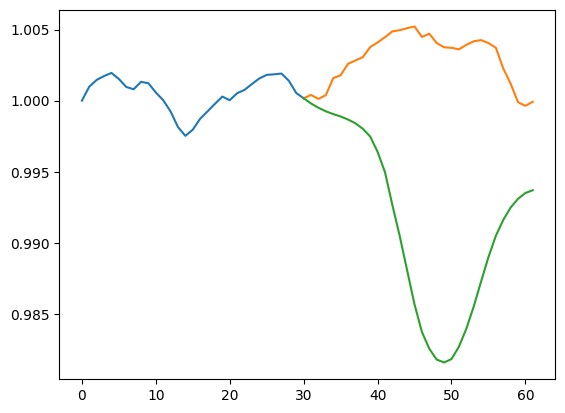

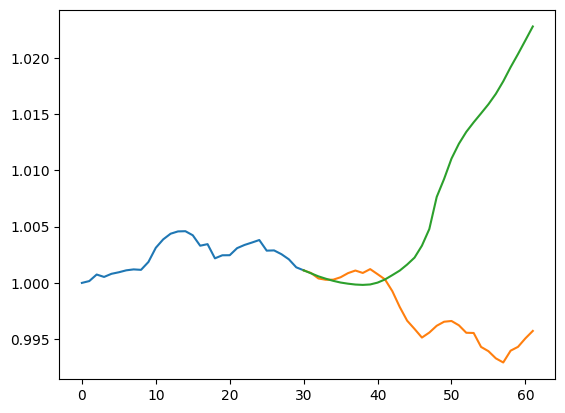

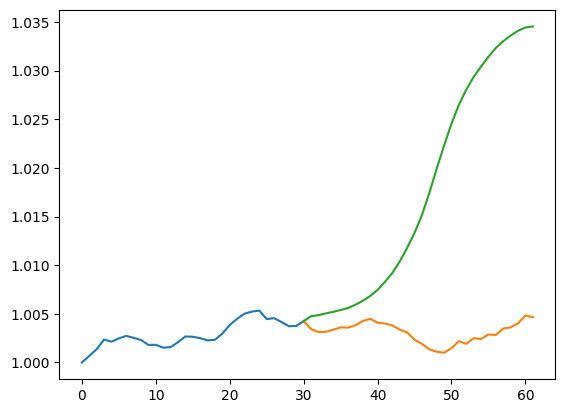

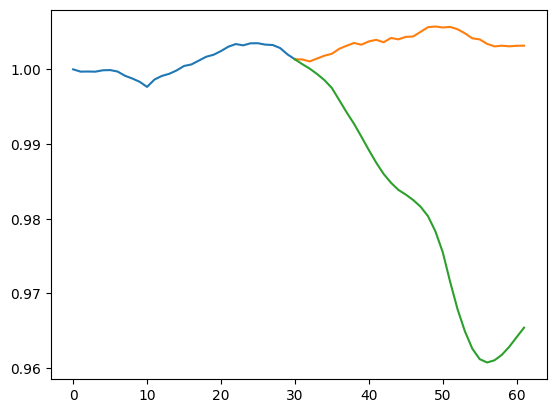

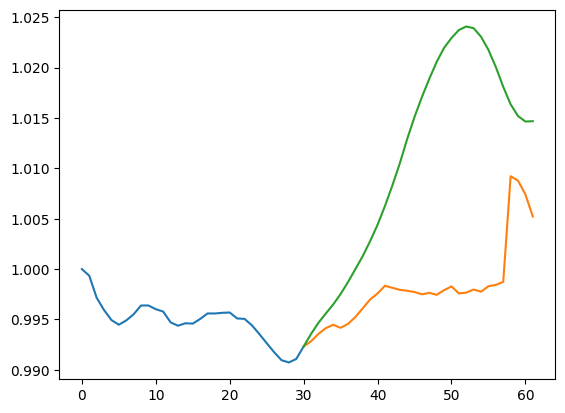

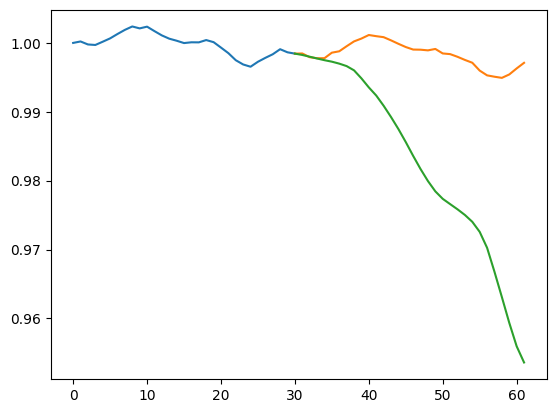

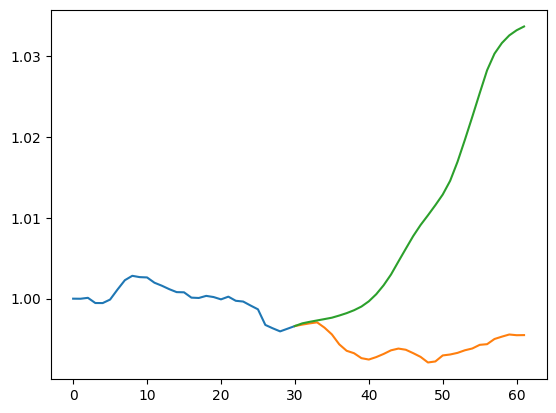

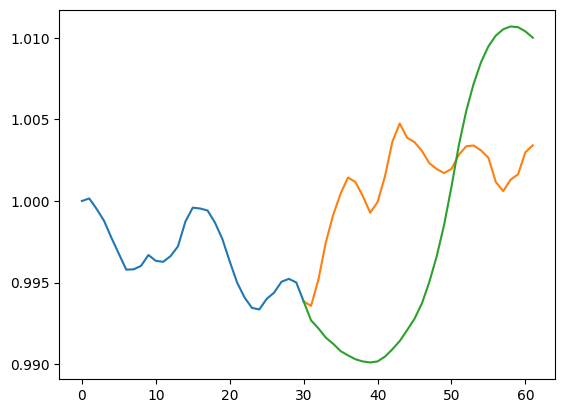

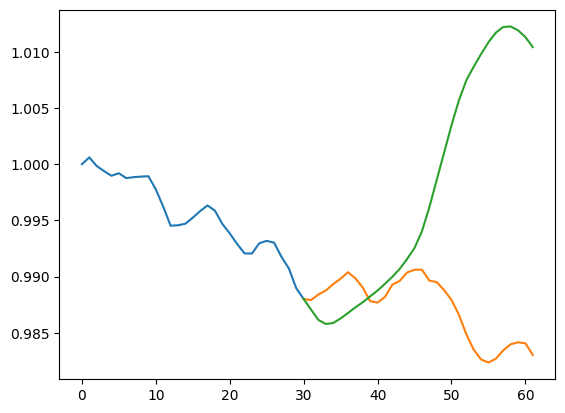

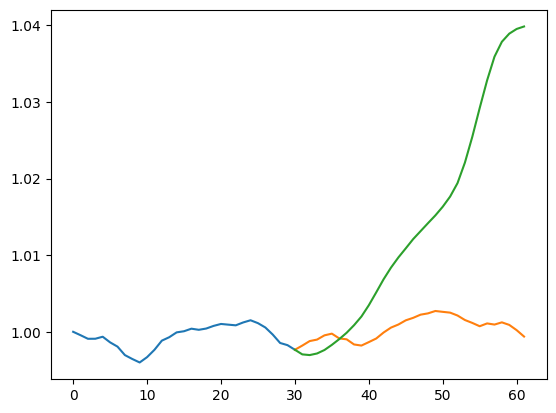

In [139]:
MASTER_CONFIG.update({
    'batch_size': 10,
})

@torch.inference_mode()
def generate(model, xs, config=MASTER_CONFIG, n_gen=30):
    model.eval()
    for _ in range(n_gen):
        logits = model(xs[:,-config['context_window']:,:])
        sx_next = logits[:,-1,:].unsqueeze(1)
        xs = torch.cat([xs, sx_next], dim=1)
    
    model.train()
    return xs

@torch.inference_mode()
def predict_test(model, future_len=10, config=MASTER_CONFIG):
    model.eval()
    xb, yb = get_batches(dataset, 'test', config, extraY=future_len)
    y_gen = generate(margay, xb, n_gen=future_len).cpu()

    print(f"xb shape: {xb.shape}")
    print(f"yb shape: {yb.shape}")
    print(f"y_pred shape: {y_gen.shape}")

    for i in range(MASTER_CONFIG['batch_size']):
        x_hist = [1]
        for pct in xb[i,:,0]/index_scale_factor:
            x_hist.append(x_hist[-1] * (1 + pct))

        y_hist = [None] * len(x_hist)
        y_hist[-1] = x_hist[-1]
        for pct in yb[i,(len(x_hist)-2):,0]/index_scale_factor:
            y_hist.append(y_hist[-1] * (1 + pct))

        y_pred = [None] * len(x_hist)
        y_pred[-1] = x_hist[-1]
        for pct in y_gen[i,(len(x_hist)-2):,0]/index_scale_factor:
            y_pred.append(y_pred[-1] * (1 + pct))

        plt.plot(x_hist)
        plt.plot(y_hist)
        plt.plot(y_pred)
        plt.show()
    
    model.train()

#############################################

predict_test(margay, future_len=30)